In [1]:

import skimage

In [2]:
import numpy as np
import cv2
import os

In [3]:
import matplotlib.pyplot as plt

In [4]:
img = cv2.imread("cow_image.jfif",0)  #loading image as gray scale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#we can also use a command :  cv2.COLOR_BGR2GRAY(img)

In [5]:
img.shape

(568, 1009)

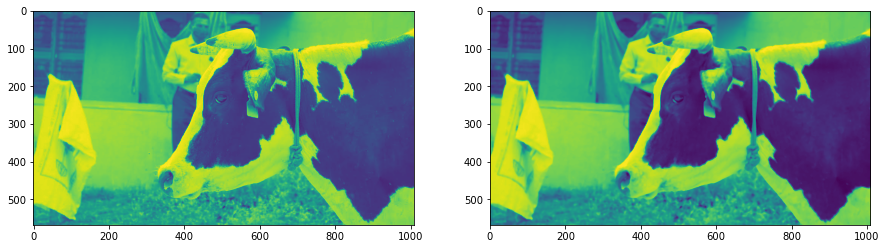

In [7]:
from skimage import filters

img_denoised = filters.median(img, selem=np.ones((5, 5)))    #applying median filter with a 3*3 sliding window.

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax0.imshow(img)
ax1.imshow(img_denoised)

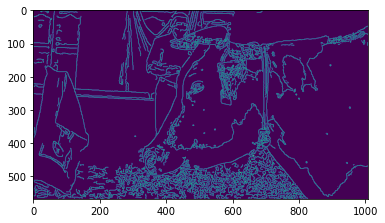

In [19]:
from skimage import feature
edges = skimage.feature.canny(img, sigma=1)    #using canny edge detector here; if we increase sigma here, noise decreases
plt.imshow(edges)                              #sobel,gaussian transformations,laplacian filters

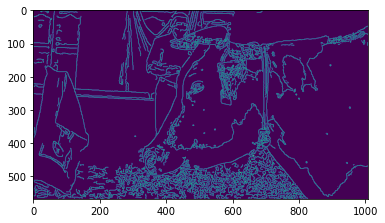

In [24]:
plt.imshow(edges*255)

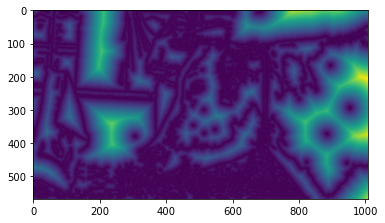

In [13]:
from scipy.ndimage import distance_transform_edt
dt = distance_transform_edt(~edges)

plt.imshow(dt)   #this is the landscape we get using watershed algorithm.

In [18]:
# local_max = feature.peak_local_max(dt, indices=False, min_distance=1)  #used to find local peaks inside image
# plt.imshow(local_max, cmap='gray')   

In [19]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=5)  #to get the exact coordinates position of peaks we use this
peak_idx[:5]        #looking at 5 coordinates

<ipython-input-19-4e6c74255b87>:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peak_idx = feature.peak_local_max(dt, indices=True, min_distance=5)  #to get the exact coordinates position of peaks we use this


array([[343, 237],
       [123, 207],
       [401, 238],
       [336, 820],
       [ 37, 211]], dtype=int64)

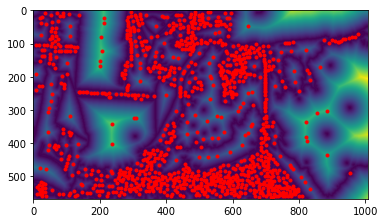

In [20]:
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')   #all the row and column coordinates
plt.imshow(dt)     #red lines are fountain positions in image which is used above.

In [21]:
from skimage import measure
markers = measure.label(local_max)

C:\Users\srisaikrishna.k\.conda\envs\deepo\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


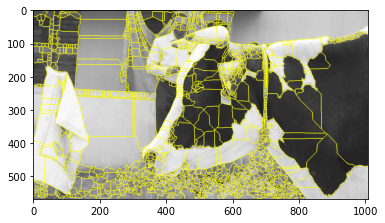

In [22]:
from skimage import morphology, segmentation   #Morphlogical transformations

labels = morphology.watershed(-dt, markers)
plt.imshow(segmentation.mark_boundaries(img, labels));   #lines are drawn around each area of segmentation.

<ipython-input-24-0912cc1eb08c>:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(labels, image=img));


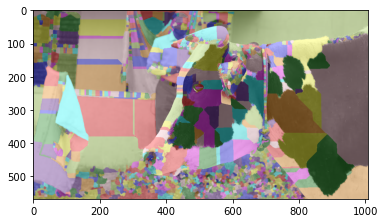

In [24]:
from skimage import color
plt.imshow(color.label2rgb(labels, image=img));

<ipython-input-25-cb9ea8d249b1>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(labels, image=img, kind='avg'), cmap='gray');
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


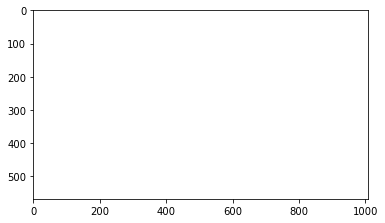

In [25]:
plt.imshow(color.label2rgb(labels, image=img, kind='avg'), cmap='gray');
#we are taking the avg values of pixels here.

In [29]:
regions = measure.regionprops(labels, intensity_image=img)

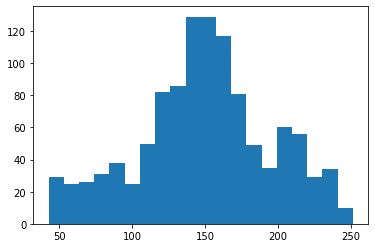

In [30]:
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20);                    #intensity difference between the regions using region properties.

In [31]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)            #clustering of fg and bg objects.

region_means = np.array(region_means).reshape(-1, 1)

In [32]:
len(region_means)

1121

In [35]:
model.fit(np.array(region_means).reshape(-1, 1))
print(model.cluster_centers_)

[[181.83555828]
 [110.4237932 ]]


In [36]:

bg_fg_labels = model.predict(region_means)
bg_fg_labels

array([0, 0, 1, ..., 0, 0, 1])

In [37]:
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg


<ipython-input-38-27e79221b5e2>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(classified_labels, image=img));


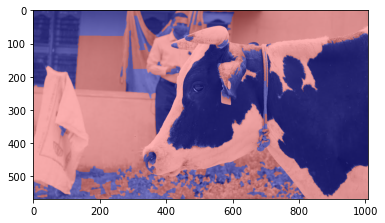

In [38]:
plt.imshow(color.label2rgb(classified_labels, image=img));

In [49]:
len(classified_labels)

168

In [56]:
np.unique(classified_labels[1])

array([0, 1])